<a href="https://colab.research.google.com/github/brendanfoo/predict_refugee_count/blob/main/MASTER_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import random
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from matplotlib.lines import Line2D
import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# connect drive to colab to load data
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#importing all gain data
df_gain = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/gain/gain.csv')
df_readiness = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/readiness/readiness.csv')
df_vulnerability = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/vulnerability.csv')

g_econ = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/readiness/economic.csv')
g_gov = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/readiness/governance.csv')
g_soc = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/readiness/social.csv')
g_cap = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/capacity.csv')
g_eco = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/ecosystems.csv')
g_exp = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/exposure.csv')
g_food = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/food.csv')
g_hab = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/habitat.csv')
g_health = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/health.csv')
g_infra = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/infrastructure.csv')
g_sens = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/GAINdata/vulnerability/sensitivity.csv')

floods = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/floods_with_ISO.csv')

population = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/pop_with_ISO.csv')

gidd = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/colab/UNHCRdata.csv', encoding='ISO-8859-1')

In [ ]:
gidd.head(1)

,ISO3,Country / Territory,Year,Event Name,Date of Event (start),Disaster Internal Displacements,Disaster Internal Displacements (Raw),Hazard Category,Hazard Type,Hazard Sub Type
0,TLS,Timor-Leste,2013,Babulu gale,2013-01-17,5,5,Weather related,Storm,Storm


In [ ]:
population.iloc[:, 1:].head(1)

,Name,Region,GENC,Year,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",ISO3
0,Afghanistan,"2008,Afghanistan",AF,2008,"27,703,539",42.5,"222,570",AFG


In [ ]:
floods.iloc[:, 1:].head(1)

,Country,Area,Began,Ended,MainCause,Severity,ISO3,Year Month
0,Indonesia,2178.65,2008-01-02,2008-01-06,Heavy rain,1.0,IDN,2008-01


In [ ]:
g_econ.head(1)

,ISO3,Name,1995,1996,1997,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AFG,Afghanistan,0.496497,0.496497,0.496497,0.496497,0.496497,0.496497,0.496497,0.496497,...,0.175065,0.178628,0.201495,0.200231,0.261156,0.238742,0.21024,0.224049,0.213706,0.213706


#constructing base data (merges)

In [ ]:
base = gidd[['ISO3', 'Date of Event (start)', 'Disaster Internal Displacements (Raw)']]
base = base.groupby(['ISO3', 'Date of Event (start)']).sum().reset_index()

In [ ]:
base['Year'] = base['Date of Event (start)'].str[:4].astype(str).astype(int)
base2 = base.rename(columns = {'Disaster Internal Displacements (Raw)': 'IDPs from Event', 'Date of Event (start)': 'Date'})

In [ ]:
base2_countries = base2['ISO3'].unique()
gain_countries = df_gain['ISO3'].unique()
extras = list(set(base2_countries) - set(gain_countries))
base3 = base2[~base2['ISO3'].isin(extras)]

In [ ]:
# this is a mess, i know

econ_col = []
gov_col = []
soc_col = []
cap_col = []
eco_col = []
exp_col = []
food_col = []
hab_col = []
health_col = []
infra_col = []
sens_col = []

for index, row in base3.iterrows():
    y = row['Year']
    c = row['ISO3']
    try:
        econ = g_econ[g_econ['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        econ = None
    try:
        gov = g_gov[g_gov['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        gov = None
    try:
        soc = g_soc[g_soc['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        soc = None
    try:
        cap = g_cap[g_cap['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        cap = None
    try:
        eco = g_eco[g_eco['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        eco = None
    try:
        exp = g_exp[g_exp['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        exp = None
    try:
        food = g_food[g_food['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        food = None
    try:
        hab = g_hab[g_hab['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        hab = None
    try:
        health = g_health[g_health['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        health = None
    try:
        infra = g_infra[g_infra['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        infra = None
    try:
        sens = g_sens[g_sens['ISO3'] == c][str(y)].iloc[0]
    except KeyError:
        sens = None

    econ_col.append(econ)
    gov_col.append(gov)
    soc_col.append(soc)
    cap_col.append(cap)
    eco_col.append(eco)
    exp_col.append(exp)
    food_col.append(food)
    hab_col.append(hab)
    health_col.append(health)
    infra_col.append(infra)
    sens_col.append(sens)

base3['Economics'] = econ_col
base3['Governance'] = gov_col
base3['Social'] = soc_col
base3['Capacity'] = cap_col
base3['Ecosystem'] = eco_col
base3['Exposure'] = exp_col
base3['Food'] = food_col
base3['Habitat'] = hab_col
base3['Health'] = health_col
base3['Infrastructure'] = infra_col
base3['Sensitivity'] = sens_col

<ipython-input-21-2c5b5d32625a>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base3['Economics'] = econ_col
<ipython-input-21-2c5b5d32625a>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base3['Governance'] = gov_col
<ipython-input-21-2c5b5d32625a>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [ ]:
base3 = base3[base3['Year'] <= 2021]

In [ ]:
base3['Date'] = pd.to_datetime(base3['Date'], errors='coerce')
base3['Year Month'] = base3['Date'].dt.strftime('%Y-%m')

<ipython-input-23-5ae3874c8476>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base3['Date'] = pd.to_datetime(base3['Date'], errors='coerce')
<ipython-input-23-5ae3874c8476>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base3['Year Month'] = base3['Date'].dt.strftime('%Y-%m')


In [ ]:
base4 = base3.merge(floods, on=['ISO3', 'Year Month'], how='inner')
base4 = base4.drop(columns = ['Year Month'])

In [ ]:
base4['Began'] = pd.to_datetime(base4['Began'], format='%Y-%m-%d')
base4['Ended'] = pd.to_datetime(base4['Ended'], format='%Y-%m-%d')
base4['Duration'] = (base4['Ended'] - base4['Began']).dt.days.astype(int)

epsilon = 1e-10
base4['Duration'] = base4['Duration'].apply(lambda x: max(x, epsilon))
base4['Severity'] = base4['Severity'].apply(lambda x: max(x, epsilon))
base4['Area'] = base4['Area'].apply(lambda x: max(x, epsilon))

base4['Magnitude'] = np.log(base4['Duration'] * base4['Severity'] * base4['Area'])
base4['Magnitude'] = np.where(base4['Magnitude'] <= 0, 0, base4['Magnitude'])

In [ ]:
fullmerge = base4.merge(population, on=['ISO3', 'Year'], how='left')
fullmerge = fullmerge.drop(columns = ['Year', 'Country', 'Name', 'Region', 'GENC', 'Unnamed: 0_x', 'Unnamed: 0_y', 'Date']) # I am dropping date here, which comes from the GIDD data, and using Began from the flood archive data as our cannonical start date. The only reason I see to give this date more weight than the GIDD is because this is what we use to calculate the magnitude column
fullmerge = fullmerge[fullmerge['IDPs from Event'] >= 0]

In [ ]:
fullmerge['ISO3'] = fullmerge['ISO3'].str[:3]

In [ ]:
fullmerge.sample(5)

,ISO3,IDPs from Event,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,...,Area,Began,Ended,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes"
928,IDN,2677,0.401037,0.453262,0.310281,0.574192,0.467547,0.517932,0.551298,0.535469,...,23321.440,2020-01-01,2020-01-05,Heavy Rain,1.0,4.0,11.443423,"272,856,400",150.6,"-197,782"
735,IDN,3000,0.789686,0.409609,0.274485,0.608491,0.469441,0.517932,0.574414,0.537826,...,22524.630,2013-12-29,2014-01-04,Heavy Rain,1.0,6.0,11.814124,"255,144,559",140.8,"-294,351"
2450,USA,1081,0.609602,0.715595,0.648210,0.242275,0.424085,0.481034,0.348626,0.450485,...,79587.680,2019-05-06,2019-05-14,Torrential Rain,1.5,8.0,13.769521,"328,329,953",35.9,"594,330"
1416,MWI,1287,0.271002,0.396166,0.166552,0.708397,0.514921,0.493184,0.622046,0.496909,...,11840.410,2017-12-16,2017-12-19,Torrential Rain,1.0,3.0,10.477886,"18,365,567",195.2,"-5,389"
2196,USA,12,0.618120,0.750582,0.647906,0.242141,0.423670,0.481034,0.348389,0.449201,...,623.434,2018-04-14,2018-04-17,Heavy Rain,1.0,3.0,7.533855,"326,838,199",35.7,"651,793"


In [ ]:
fullmerge.columns

Index(['ISO3', 'IDPs from Event', 'Economics', 'Governance', 'Social',
       'Capacity', 'Ecosystem', 'Exposure', 'Food', 'Habitat', 'Health',
       'Infrastructure', 'Sensitivity', 'Area', 'Began', 'Ended', 'MainCause',
       'Severity', 'Duration', 'Magnitude', 'Population',
       'Population Density (People per Sq. Km.)',
       'Net international migrants, both sexes'],
      dtype='object')

In [ ]:
fullmerge_scaledy = fullmerge.copy(deep=True)[['ISO3', 'IDPs from Event', 'Area', 'Began']]

fullmerge_scaledy['Began'] = pd.to_datetime(fullmerge_scaledy['Began'], errors='coerce')
fullmerge_scaledy['Year_Month'] = fullmerge_scaledy['Began'].dt.strftime('%Y-%m')

fullmerge_scaledy['Total_Group_Area'] = fullmerge_scaledy.groupby(['IDPs from Event', 'ISO3', 'Year_Month'])['Area'].transform('sum')
fullmerge_scaledy['Scaled_IDP'] = fullmerge_scaledy['Area'] * fullmerge_scaledy['IDPs from Event'] / fullmerge_scaledy['Total_Group_Area']

fullmerge['Scaled_IDP'] = np.ceil(fullmerge_scaledy['Scaled_IDP']).astype(int)
fullmerge[['ISO3', 'IDPs from Event', 'Began', 'Area', 'Scaled_IDP']].sort_values('IDPs from Event')

,ISO3,IDPs from Event,Began,Area,Scaled_IDP
2511,USA,1,2019-12-28,138726.87,1
1144,IND,1,2020-06-20,59427.38,1
1143,IND,1,2020-06-02,199450.79,1
650,GRC,1,2016-11-26,36417.46,1
892,IDN,2,2018-12-05,136439.91,2
...,...,...,...,...,...
1114,IND,2623349,2019-06-27,67022.92,2623349
463,CHN,3760000,2020-06-15,251526.70,1841837
464,CHN,3760000,2020-06-29,154387.06,1130520
465,CHN,3760000,2020-06-27,107563.03,787645


In [ ]:
fullmerge.head()

,ISO3,IDPs from Event,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,...,Began,Ended,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP
0,AFG,270,0.178628,0.172592,0.335777,0.757451,0.507907,0.480512,0.580916,0.537736,...,2013-04-23,2013-04-29,Torrential Rain,1.0,6.0,11.384192,"31,098,161",47.7,"-67,219",270
1,AFG,740,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115",740
2,AFG,244,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115",245
3,AFG,5775,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-06-03,2014-06-10,Heavy Rain,1.5,7.0,13.047944,"31,809,829",48.8,"-58,115",5775
4,AFG,46380,0.210240,0.158260,0.354043,0.711203,0.509198,0.480512,0.615954,0.534952,...,2018-05-09,2018-05-22,Torrential Rain,1.5,13.0,15.095260,"34,907,481",53.5,"-21,703",46380


In [ ]:
fullmerge.iloc[:, 20:30].head(3)

,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP
0,"31,098,161",47.7,"-67,219",270
1,"31,809,829",48.8,"-58,115",740
2,"31,809,829",48.8,"-58,115",245


In [ ]:
fullmerge.to_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/FULLMERGE.csv')

#Feature Engineering / Export (Linear Regression)

OHE catagorical variables like:
- Country
- MainCause
- Month of Event Began

Drop other date encodings since we are just including month

In [ ]:
lrdf = fullmerge.copy(deep = True).drop(columns = ['Ended'])

In [ ]:
country_ohe = pd.get_dummies(lrdf['ISO3'], drop_first = True) # after a bit of googling, it seems like dropping one col (drop_first) avoids the issue of freaking out LR by having colinear cols
month_ohe = pd.get_dummies(lrdf['Began'].dt.month, drop_first = True)

In [ ]:
lrdf = lrdf.drop(columns = ['ISO3', 'Began'])
lrdf = lrdf.join(country_ohe)
lrdf = lrdf.join(month_ohe)

MainCause is a bit of a mess, manually entered, let's simplify it before OHE

In [ ]:
lrdf['MainCause'].unique()

array(['Torrential Rain', 'Heavy Rain', 'Heavy Rain and Snowmelt',
       'Heavy rain', 'Dam Break, Heavy Rain',
       'Tropical Storm and Heavy Rain', 'Heavy Rain, Tropical Cycl',
       'Monsoonal Rain', 'Tropical Storm Oswald', 'Tropical Storm Marcia',
       'Tropical Cyclone Debbie', 'Monsoon Rains',
       'Tropical Storm Mahasen', 'Tropical Storm Joaquin',
       'Brief torrential rain', 'Dam Break', 'Snowmelt',
       'Ice jam/break-up', 'Snowmelt and Heavy Rain',
       'Heavy Rain and Ice Melt', 'Ice Jam', 'Tropical  Storm Fenshen',
       'Tropical Storm Fung-Wong', 'Torrential rain',
       'Tropical Storm Kammuri', 'Tropical Storm Sulik',
       'Heavy Rain, began with #4079', 'Tropical Storm Utor',
       'Tropical Storm Fitow', 'Typhoon Rammasun',
       'Tropical Storm Maysak', 'Tropical Storm Meranti',
       'Tropical Storm Hato', 'Tropical Storm Ewiniar',
       'Monsoonal Rain and Dam release', 'Brief Torrential Rain',
       'Tropical Storm Otto', 'Tropical Storm 

My main causes:
- types of storms
- dam issues
- rain
- various forms of frozen water melting
- tides or tsunami



Rules for MainCause replacement:
- For every row, replace "MainCause" with 5 columns, one for each of the above, with a 0 or 1 indicating those words included in MainCause
- this is *not* a OHE
- 1) reduce MainCause to lower case
- 2) create 4 columns filled with 0s,
- 3) iterate through rows and have 4 if statements to fill ones where relevant based on str.contains

In [ ]:
lrdf['MainCause'] = lrdf['MainCause'].str.lower()

In [ ]:
lrdf['Storms'] = np.zeros(lrdf.shape[0])
lrdf['DamBreak'] = np.zeros(lrdf.shape[0])
lrdf['Rain'] = np.zeros(lrdf.shape[0])
lrdf['Melting'] = np.zeros(lrdf.shape[0])
lrdf['TidesTsunami'] = np.zeros(lrdf.shape[0])

In [ ]:
for index, row in lrdf.iterrows():
  maincause = row['MainCause']
  if ('tropical' in maincause) or ('storm' in maincause) or ('monsoon' in maincause) or ('cyclone' in maincause) or ('typhoon' in maincause):
    lrdf.loc[index, 'Storms'] = 1
  if ('dam' in maincause):
    lrdf.loc[index, 'DamBreak'] = 1
  if ('rain' in maincause):
    lrdf.loc[index, 'Rain'] = 1
  if ('snow' in maincause) or ('ice' in maincause) or ('glacier' in maincause) or ('jökulhlaup' in maincause):
    lrdf.loc[index, 'Melting'] = 1
  if ('tide' in maincause) or ('tsunami' in maincause):
    lrdf.loc[index, 'TidesTsunami'] = 1

In [ ]:
lrdf = lrdf.drop(columns = ['MainCause'])

In [ ]:
for col in lrdf.columns:
  print(col, end=' | ')

IDPs from Event | Economics | Governance | Social | Capacity | Ecosystem | Exposure | Food | Habitat | Health | Infrastructure | Sensitivity | Area | Severity | Duration | Magnitude | Population | Population Density (People per Sq. Km.) | Net international migrants, both sexes | Scaled_IDP | AGO | ALB | ARG | AUS | AUT | BDI | BFA | BGD | BGR | BHS | BIH | BOL | BRA | BTN | BWA | CAF | CAN | CHE | CHL | CHN | CMR | COL | CRI | CUB | DEU | DOM | DZA | ECU | EGY | ESP | ETH | FJI | FRA | GBR | GEO | GHA | GIN | GRC | GTM | GUY | HND | HRV | HTI | HUN | IDN | IND | IRN | IRQ | ISR | ITA | JPN | KAZ | KEN | KHM | KOR | LBR | LKA | MAR | MDG | MEX | MKD | MLI | MMR | MNG | MOZ | MRT | MUS | MWI | MYS | NAM | NGA | NIC | NPL | NZL | OMN | PAK | PAN | PER | PHL | PNG | POL | PRK | PRT | PRY | ROU | RUS | RWA | SAU | SDN | SEN | SLB | SLE | SLV | SOM | SRB | SVK | TCD | THA | TJK | TUN | TUR | TZA | UGA | UKR | URY | USA | UZB | VCT | VEN | VNM | VUT | YEM | ZAF | ZMB | ZWE | 2 | 3 | 4 | 5 | 6

finally, we make absolutely certain everything is encoded as a number and non-null

In [ ]:
lrdf = lrdf.replace(',','', regex=True)
lrdf = lrdf.replace('--','0', regex=True)
lrdf = lrdf.astype(float)
lrdf.shape

(2746, 151)

In [ ]:
lrdf = lrdf.dropna()
lrdf.shape

(2622, 151)

and we can export for modeling

In [ ]:
lrdf.to_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/LRDATA.csv')

# Feature Engineering / Export (Time Series)

In [ ]:
tsdf = fullmerge.copy(deep = True).drop(columns = ['Ended'])
tsdf.columns

Index(['ISO3', 'IDPs from Event', 'Economics', 'Governance', 'Social',
       'Capacity', 'Ecosystem', 'Exposure', 'Food', 'Habitat', 'Health',
       'Infrastructure', 'Sensitivity', 'Area', 'Began', 'MainCause',
       'Severity', 'Duration', 'Magnitude', 'Population',
       'Population Density (People per Sq. Km.)',
       'Net international migrants, both sexes', 'Scaled_IDP'],
      dtype='object')

I'm gonig to do the same changes to MainCause we did for linear regression because I feel that's a more effecient / interpretable encoding I think may be more useful in modeling

In [ ]:
tsdf['MainCause'] = tsdf['MainCause'].str.lower()

tsdf['Storms'] = np.zeros(tsdf.shape[0])
tsdf['DamBreak'] = np.zeros(tsdf.shape[0])
tsdf['Rain'] = np.zeros(tsdf.shape[0])
tsdf['Melting'] = np.zeros(tsdf.shape[0])
tsdf['TidesTsunami'] = np.zeros(tsdf.shape[0])

for index, row in tsdf.iterrows():
  maincause = row['MainCause']
  if ('tropical' in maincause) or ('storm' in maincause) or ('monsoon' in maincause) or ('cyclone' in maincause) or ('typhoon' in maincause):
    tsdf.loc[index, 'Storms'] = 1
  if ('dam' in maincause):
    tsdf.loc[index, 'DamBreak'] = 1
  if ('rain' in maincause):
    tsdf.loc[index, 'Rain'] = 1
  if ('snow' in maincause) or ('ice' in maincause) or ('glacier' in maincause) or ('jökulhlaup' in maincause):
    tsdf.loc[index, 'Melting'] = 1
  if ('tide' in maincause) or ('tsunami' in maincause):
    tsdf.loc[index, 'TidesTsunami'] = 1

tsdf = tsdf.drop(columns = ['MainCause'])

unless any other changes are necessary, we can export

In [ ]:
tsdf.to_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/TSDATA.csv')

In [ ]:
tsdf.head(5)

,ISO3,IDPs from Event,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,...,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP,Storms,DamBreak,Rain,Melting,TidesTsunami
0,AFG,270,0.178628,0.172592,0.335777,0.757451,0.507907,0.480512,0.580916,0.537736,...,11.384192,"31,098,161",47.7,"-67,219",270,0.0,0.0,1.0,0.0,0.0
1,AFG,740,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,14.998823,"31,809,829",48.8,"-58,115",740,0.0,0.0,1.0,0.0,0.0
2,AFG,244,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,14.998823,"31,809,829",48.8,"-58,115",245,0.0,0.0,1.0,0.0,0.0
3,AFG,5775,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,13.047944,"31,809,829",48.8,"-58,115",5775,0.0,0.0,1.0,0.0,0.0
4,AFG,46380,0.210240,0.158260,0.354043,0.711203,0.509198,0.480512,0.615954,0.534952,...,15.095260,"34,907,481",53.5,"-21,703",46380,0.0,0.0,1.0,0.0,0.0


#Feature Engineering / Export (Catagorical Outputs)

<ipython-input-35-a6d2590156a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['binnedIDPs'] = cat.groupby('ISO3')['Scaled_IDP'].apply(lambda x: pd.qcut(x, 3, duplicates = 'drop', labels = False).astype(str))


<Axes: >

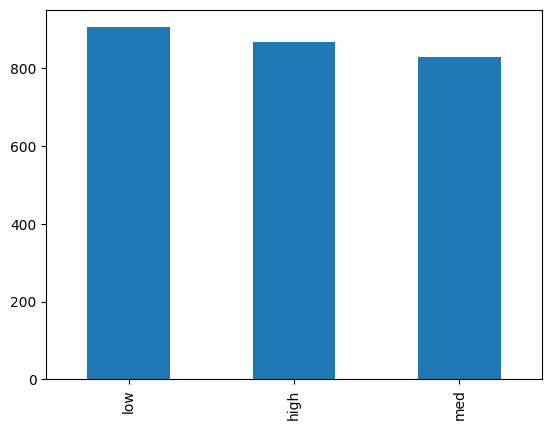

In [ ]:
cat = fullmerge.copy(deep = True)
cat = cat.dropna()
cat['binnedIDPs'] = cat.groupby('ISO3')['Scaled_IDP'].apply(lambda x: pd.qcut(x, 3, duplicates = 'drop', labels = False).astype(str))
cat = cat[~(cat['binnedIDPs'] == 'nan')]
def label(x):
  if x == '0':
    return 'low'
  if x == '1':
    return 'med'
  if x == '2':
    return 'high'
  return 'damn it'
cat['binnedIDPs'] = cat['binnedIDPs'].apply(label)
cat['binnedIDPs'].value_counts().plot(kind='bar')

In [ ]:
cat = cat.drop(columns = ['Began', 'Ended'])

In [ ]:
label_encoder = LabelEncoder()
cat['MainCause'] = label_encoder.fit_transform(cat['MainCause'])

In [ ]:
label_encoder = LabelEncoder()
cat['ISO3'] = label_encoder.fit_transform(cat['ISO3'])

In [ ]:
cat.iloc[:, :-1] = cat.iloc[:, :-1].replace(',','', regex=True)
cat.iloc[:, :-1] = cat.iloc[:, :-1].replace('--','0', regex=True)
cat.iloc[:, :-1] = cat.iloc[:, :-1].astype(float)
cat.dtypes

<ipython-input-39-0371cf818458>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cat.iloc[:, :-1] = cat.iloc[:, :-1].astype(float)


ISO3                                       float64
IDPs from Event                            float64
Economics                                  float64
Governance                                 float64
Social                                     float64
Capacity                                   float64
Ecosystem                                  float64
Exposure                                   float64
Food                                       float64
Habitat                                    float64
Health                                     float64
Infrastructure                             float64
Sensitivity                                float64
Area                                       float64
MainCause                                  float64
Severity                                   float64
Duration                                   float64
Magnitude                                  float64
Population                                 float64
Population Density (People per 

In [ ]:
cat=cat.dropna()

In [ ]:
cat = cat.drop(columns = ['IDPs from Event'])
cat.to_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/CATIDPS.csv', index = False)

# Visualization: Histogram of Distribution of IDP Counts

In [ ]:
cat_copy = cat.copy()

cat_copy = cat_copy[cat_copy ['Scaled_IDP'] <= 100000]
cat_copy.head()

,ISO3,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,...,Area,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP,binnedIDPs
31,0.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,12133.31,56.0,1.5,14.0,12.448232,27292819.0,21.9,14473.0,2125.0,high
32,0.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,10252.79,56.0,1.5,14.0,12.279828,27292819.0,21.9,14473.0,1796.0,high
33,0.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,12133.31,56.0,1.5,14.0,12.448232,27292819.0,21.9,14473.0,647.0,med
34,0.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,10252.79,56.0,1.5,14.0,12.279828,27292819.0,21.9,14473.0,546.0,med
35,0.0,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,12133.31,56.0,1.5,14.0,12.448232,27292819.0,21.9,14473.0,262.0,low


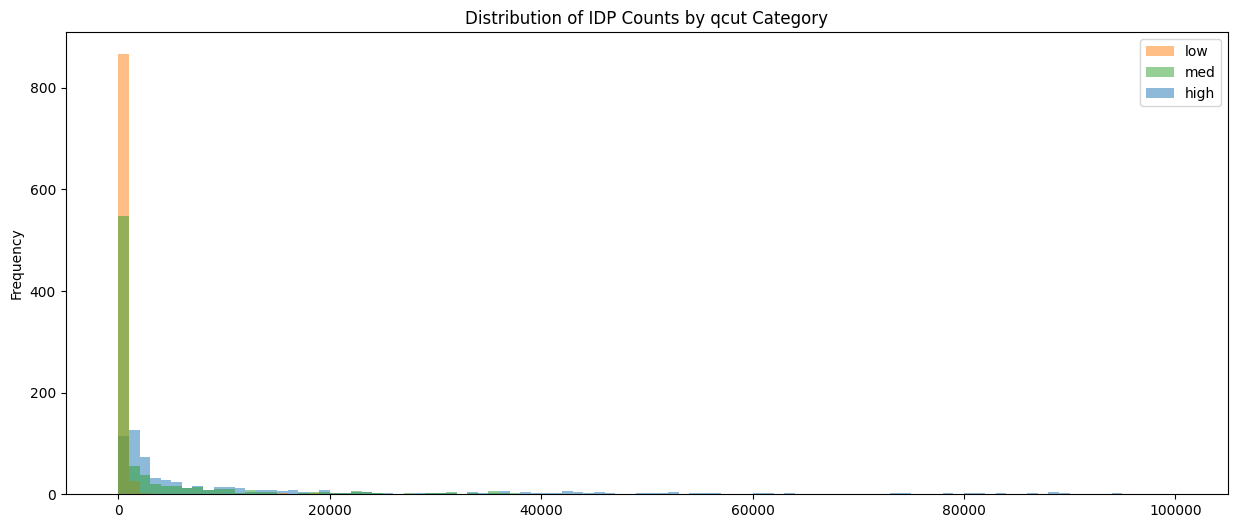

In [ ]:
# histogram of the distribution of IDP counts color coded
# by there qcut category for the categorical models

plt.rcParams["figure.figsize"] = (15,6)

cat_copy.pivot(columns='binnedIDPs', values='Scaled_IDP').plot.hist(bins=100,alpha=0.5)

# Order legend from low to high
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]

# Add legend and title to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.title('Distribution of IDP Counts by qcut Category')

plt.show()